In [ ]:
!pip install category_encoders
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.9 MB/s eta 0:00:00


In [ ]:
train_data = pd.read_csv('/content/sample_data/train.csv')
test_data = pd.read_csv('/content/sample_data/test.csv')

# Test: 1459 rows
# Train: 1460 rows

# print(train_data.columns)
# print('train data num of columns: ', len(train_data.columns))
# print(test_data.columns)
# print('test data num of columns: ', len(test_data.columns))
test_data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
5,1466,60,RL,75.0,10000,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
6,1467,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,500,3,2010,WD,Normal
7,1468,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
8,1469,20,RL,85.0,10176,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
9,1470,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,4,2010,WD,Normal


In [ ]:
# drop id
print(train_data.shape)

train_data.drop(columns=['Id'], inplace=True)

print(train_data.shape)

(1460, 81)
(1460, 80)


## Exploratory Data Analysis

Mean Sale Price: 180921.19589041095
Median Sale Price: 163000.0
Standard Deviation: 79442.50288288662


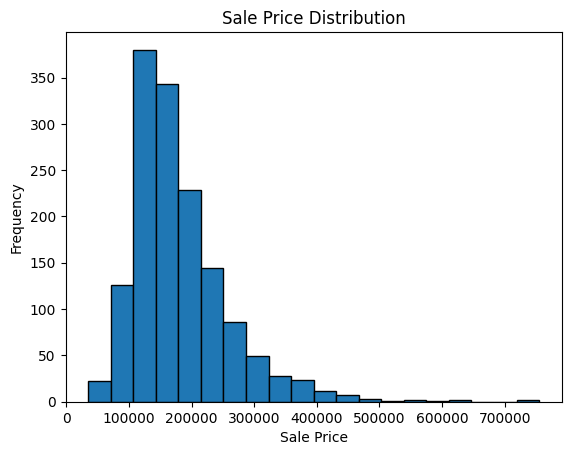

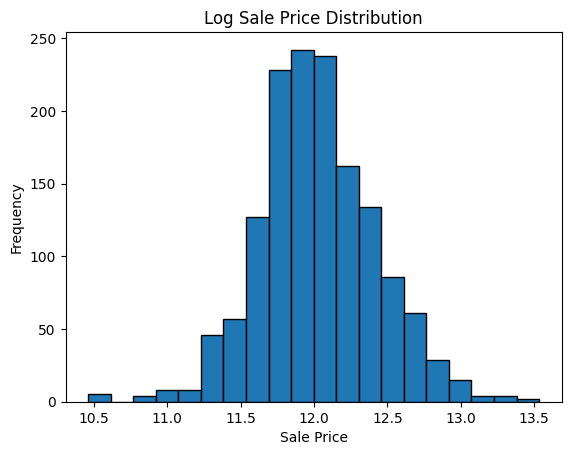

In [ ]:
# Is the distribution of labels balanced? Find the probability of different categories.

# Summary statistics
train_df = train_data
mean_price = train_df['SalePrice'].mean()
median_price = train_df['SalePrice'].median()
std_deviation = train_df['SalePrice'].std()

print(f"Mean Sale Price: {mean_price}")
print(f"Median Sale Price: {median_price}")
print(f"Standard Deviation: {std_deviation}")

# Create a histogram to visualize the distribution
plt.hist(train_df['SalePrice'], bins=20, edgecolor='k')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.title('Sale Price Distribution')
plt.show()

plt.hist(np.log(train_df['SalePrice']), bins=20, edgecolor='k')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.title('Log Sale Price Distribution')
plt.show()

These statistics indicate that this dataset of sale prices has some variability, with sale prices ranging from below `$100,000 to above $300,000.` The difference between the mean and median suggests that there may be some higher-priced properties (outliers) that are contributing to the higher mean.

In [ ]:
numerical = []
categorical = []
ind = train_data.dtypes.index
dtypes = train_data.dtypes

for i in range(len(dtypes)):
  if dtypes[i] == object:
    categorical.append(ind[i])
  else:
    numerical.append(ind[i])

# These are actually categorical
for cat in ["MSSubClass", "OverallQual", "OverallCond"]:
  numerical.remove(cat)
  categorical.append(cat)
numerical.remove('SalePrice')

print(f'There are {len(numerical)} numerical features: {numerical}')
print(f'There are {len(categorical)} categorical features: {categorical}')

There are 33 numerical features: ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
There are 46 categorical features: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 

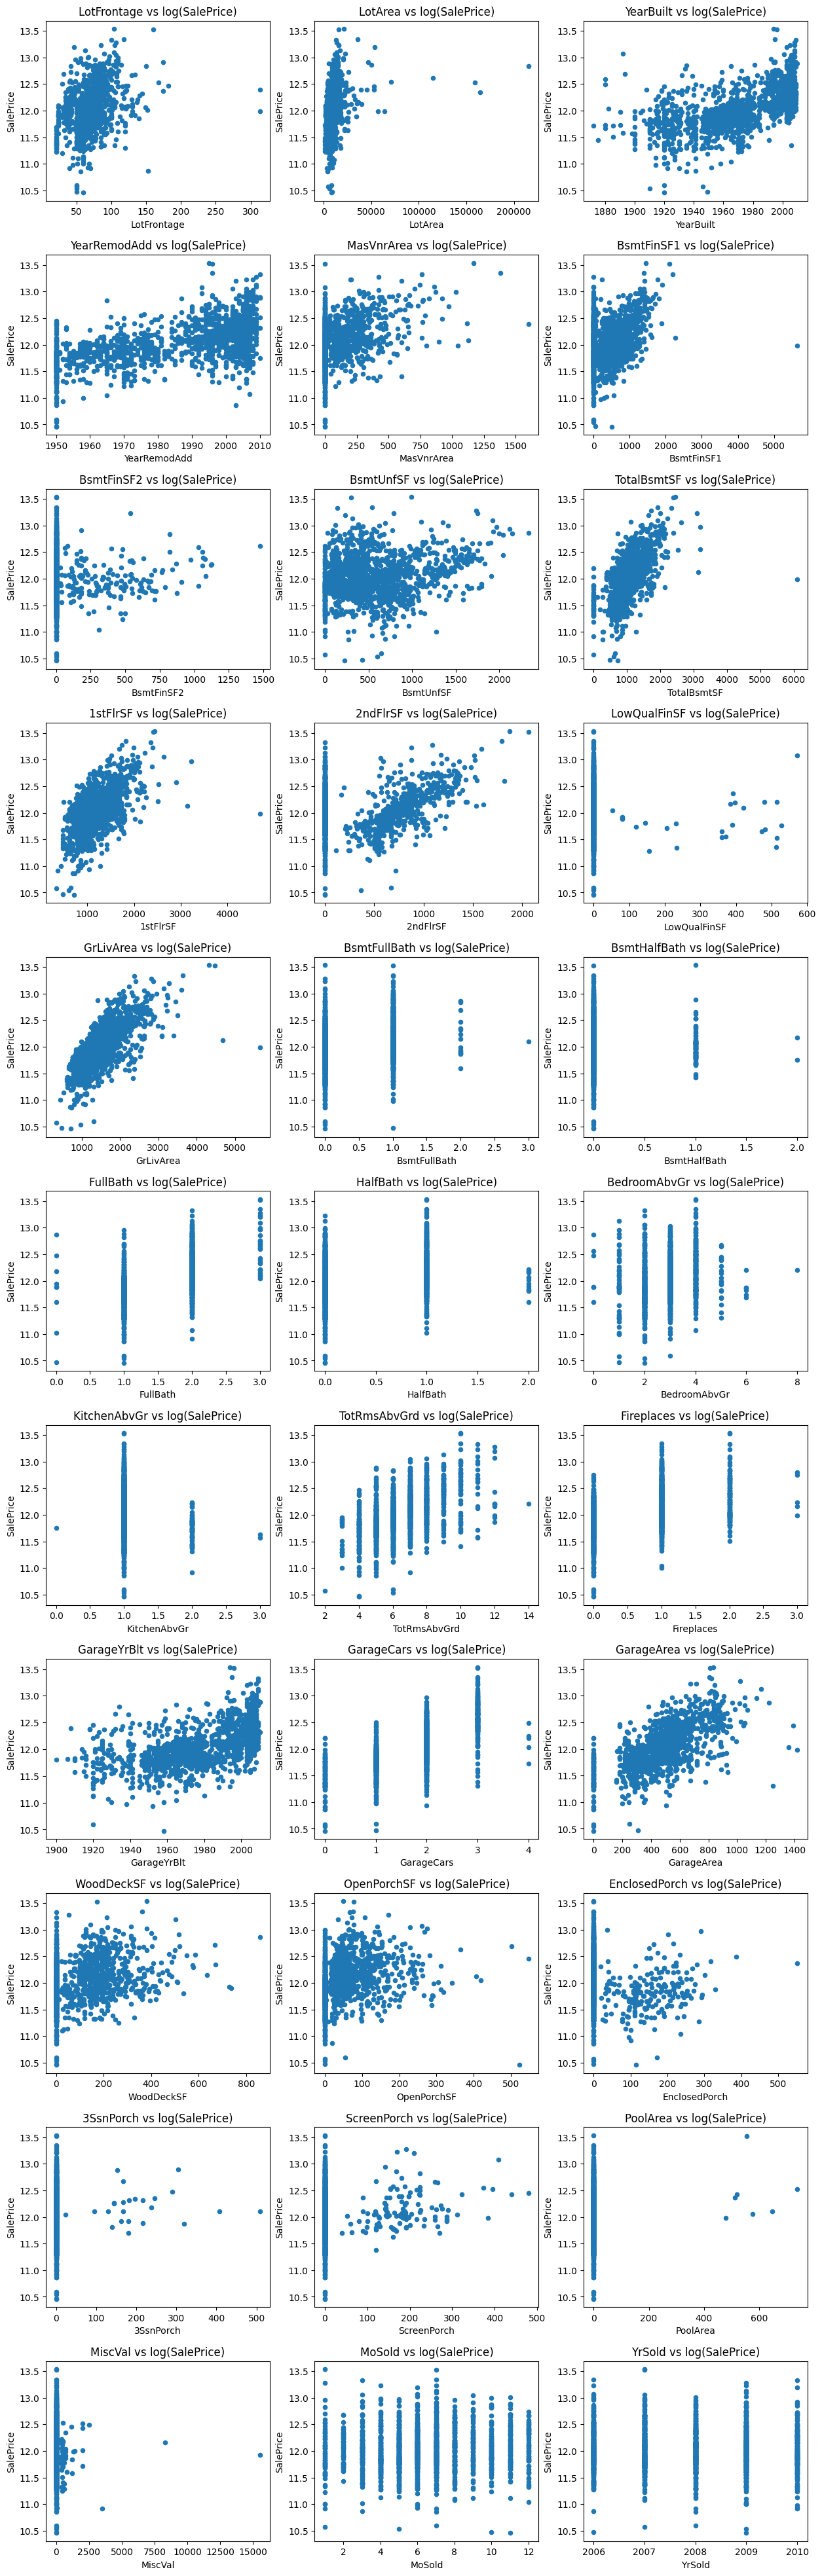

In [ ]:
transformed_train_df = train_data.copy()
transformed_train_df["SalePrice"] = np.log(transformed_train_df["SalePrice"])

numrows=3
numcols=11
fig, axs = plt.subplots(numcols,numrows, figsize=(15, 50))
plt.subplots_adjust(hspace=0.3)

# plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3, hspace=0.3)

i=0
j=0
for num in numerical:
  plot_df = transformed_train_df[[num, 'SalePrice']]
  plot_df.plot.scatter(x=num, y='SalePrice', title=f'{num} vs log(SalePrice)', ax=axs[i,j])

  if j==numrows-1:
    i+=1
    j=0
  else:
    j+=1

# Histograms are not very useful since most features have many 0s

  # msSub_df.plot.hist(column=num, title=f'{num} histogram', ax=axs[i,j])
  # if j==numrows-1:
  #   i+=1
  #   j=0
  # else:
  #   j+=1


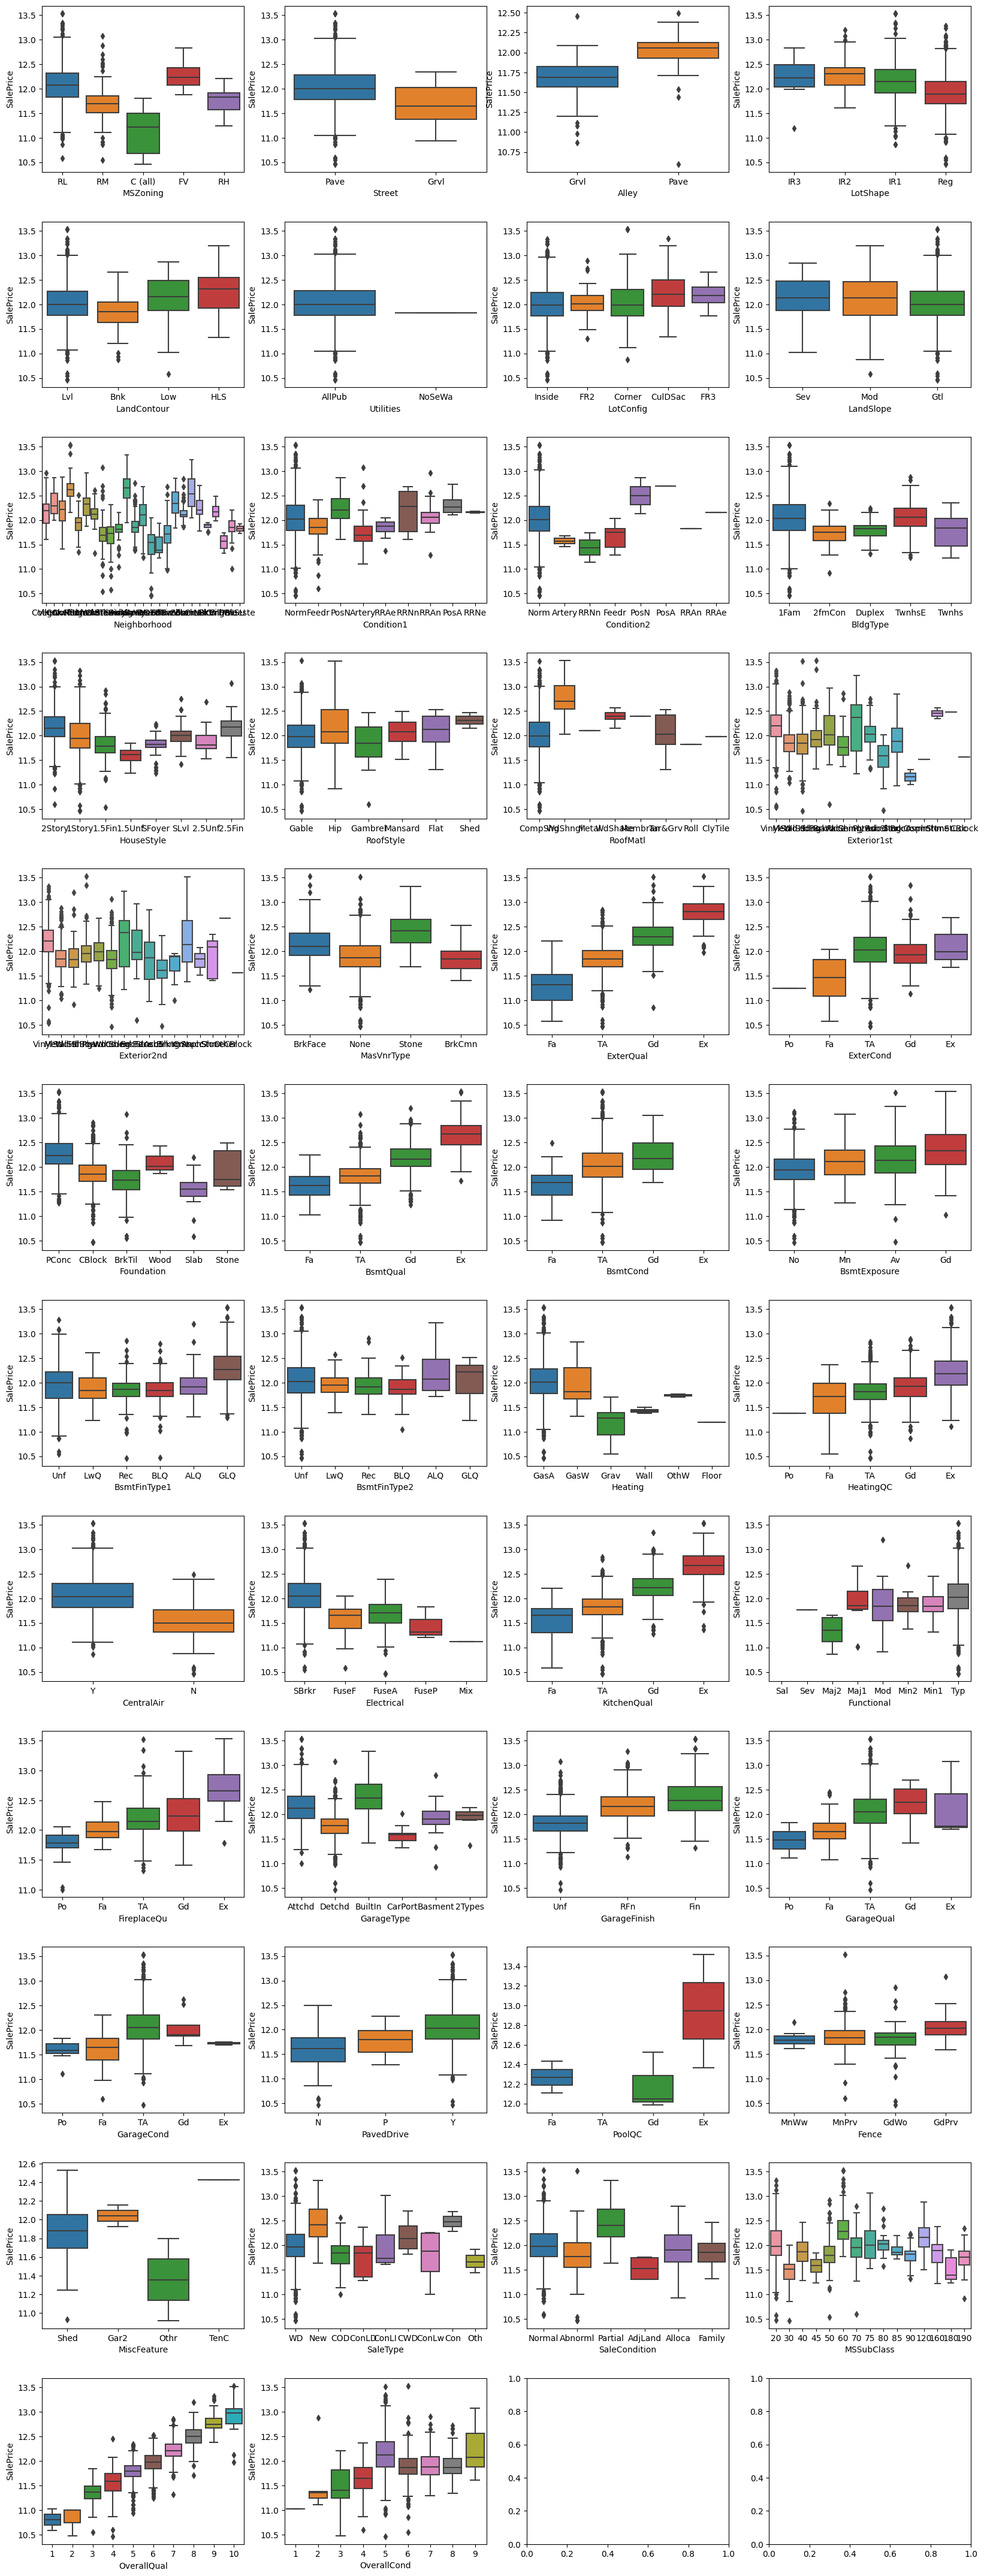

In [ ]:
orders = {
    'FireplaceQu': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],
    'LandSlope': ['Sev', 'Mod',	'Gtl'],
    'ExterQual': ['Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtFinType1': ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFinType2': ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'GarageFinish': ['Unf', 'RFn', 'Fin'],
    'PavedDrive': ['N', 'P', 'Y'],
    'Fence': ['MnWw', 'MnPrv', 'GdWo', 'GdPrv'],
    'BsmtExposure': ['No', 'Mn', 'Av', 'Gd'],
    'BsmtQual': ['Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': ['Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Fa', 'TA', 'Gd', 'Ex'],
    'PoolQC': ['Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'FireplaceQu': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex']
    }


numrows = 4
numcols = 12
fig, axs = plt.subplots(numcols, numrows, figsize=(20, 55))
plt.subplots_adjust(hspace=0.3)

i=0
j=0
for cat in categorical:
  if cat in orders.keys():
    sns.boxplot(x=cat, y='SalePrice', data=transformed_train_df, order=orders[cat], ax=axs[i,j])
  else:
    sns.boxplot(x=cat, y='SalePrice', data=transformed_train_df, ax=axs[i,j])

  if j==numrows-1:
    i+=1
    j=0
  else:
    j+=1

In [ ]:
# These features don't add much, either because there is no correlation,
#  or there aren't that many unique labels, or the labels are highly imbalanced
# Let's examine each features' label distribution to see how much information they add

potentially_useless = ['Utilities', 'PoolArea', 'MiscVal', '3SsnPorch', 'LowQualFinSF', 'BsmtHalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'MoSold', 'YrSold', 'GarageCond', 'LandSlope', 'LotConfig', 'BsmtFinType2']
for feat in potentially_useless:
  print(f'{feat}: \n')
  print(train_data[feat].value_counts())
  print('\n')

# Some of these don't add any information. For example, Utilities has 1458 AllPub but only 1 NoSeWa. This is highly imbalanced

# We should drop these? due to their lack of information/correlation:
drop_useless_feats = ['Utilities', 'PoolArea', '3SsnPorch', 'LowQualFinSF', 'GarageCond', 'LandSlope', 'LotConfig', 'BsmtFinType2']

# Tried dropping more features with questionable correlation, but this did not improve performance
# drop_more_useless_feats = ['BsmtFullBath','BsmtHalfBath','HalfBath', 'BedroomAbvGr','KitchenAbvGr','ScreenPorch','MiscVal',
                          #  'MoSold','YrSold','BldgType','RoofStyle','BsmtExposure','BsmtFinType1','Fence']

Utilities: 

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64


PoolArea: 

0      1453
512       1
648       1
576       1
555       1
480       1
519       1
738       1
Name: PoolArea, dtype: int64


MiscVal: 

0        1408
400        11
500         8
700         5
450         4
600         4
2000        4
1200        2
480         2
15500       1
800         1
350         1
3500        1
1300        1
54          1
620         1
560         1
1400        1
8300        1
1150        1
2500        1
Name: MiscVal, dtype: int64


3SsnPorch: 

0      1436
168       3
144       2
180       2
216       2
290       1
153       1
96        1
23        1
162       1
182       1
196       1
320       1
245       1
238       1
508       1
140       1
130       1
407       1
304       1
Name: 3SsnPorch, dtype: int64


LowQualFinSF: 

0      1434
80        3
360       2
205       1
479       1
397       1
514       1
120       1
481       1
232       1
53        1
515       1
156   

In [ ]:
print(train_data.shape)
train_data.drop(columns=drop_useless_feats, inplace=True)
# train_data.drop(columns=drop_more_useless_feats, inplace=True)
print(train_data.shape)

(1460, 80)
(1460, 72)


## Missing Value Imputation

features missing in train data: 
 Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'Electrical', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'PoolQC',
       'Fence', 'MiscFeature'],
      dtype='object')


<Axes: title={'center': 'percent of values missing in train and test'}, xlabel='feature'>

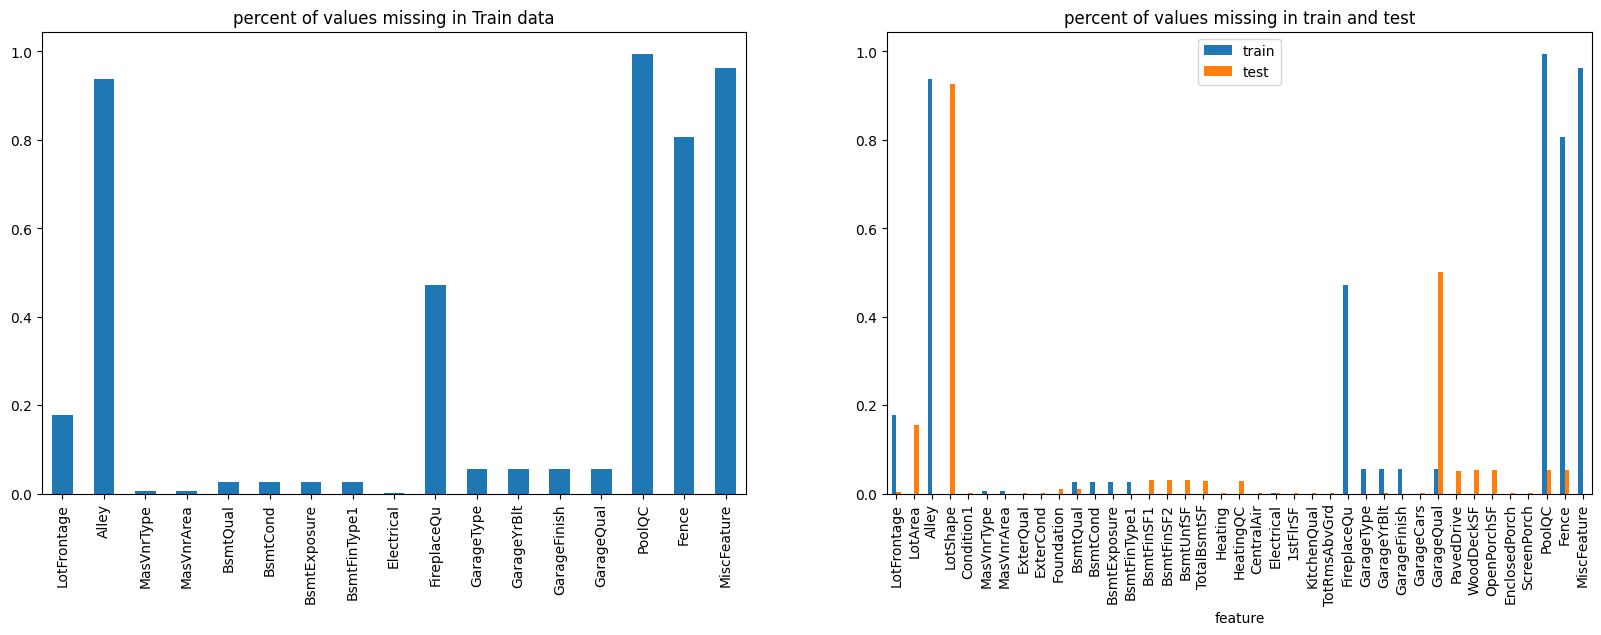

In [ ]:
# fig, axs = plt.subplots(1,3, figsize=(20,6))
fig, axs = plt.subplots(1,2, figsize=(20,6))


def plotMissing(df, title, ax_ind):
  ax = df.plot.bar(x='feature', y='percent missing', title='percent of values missing in '+title, ax=axs[ax_ind])
  ax.set_xlabel('feature')
  ax.set_ylabel('percent_missing')


is_null_df = train_data.isnull().sum()/len(train_data)
is_null_df_subplot = is_null_df[is_null_df>0.0]

is_null_df2 = test_data.isnull().sum()/len(test_data)
is_null_df2_subplot = is_null_df2[is_null_df2>0.0]

print('features missing in train data: \n', is_null_df_subplot.index)
# print('features missing only in train data: \n', is_null_df_subplot.index.difference(is_null_df2_subplot.index))
# print('\n')
# print('features missing only in test data: \n', is_null_df2_subplot.index.difference(is_null_df_subplot.index))
is_null_test_only_subplot = is_null_df2[is_null_df2_subplot.index.difference(is_null_df_subplot.index)]
# print('\n')


# plotMissing(is_null_df_subplot, 'Train data', 0)
# plotMissing(is_null_df2_subplot, 'Test data', 1)
# plotMissing(is_null_test_only_subplot, 'only Test data', 2)

is_null_df_subplot.plot.bar(x='feature', y='percent missing', title='percent of values missing in Train data', ax=axs[0])



is_null_df = pd.DataFrame({'feature':is_null_df.index, 'train':is_null_df.values})
is_null_df2 = pd.DataFrame({'feature':is_null_df2.index, 'test':is_null_df2.values})
is_null_df['test'] = is_null_df2['test']
is_null_df.dropna(inplace=True)

is_null_df.set_index('feature', inplace=True)


is_null_df = is_null_df[(is_null_df['train']>0) | (is_null_df['test']>0)]

is_null_df.plot.bar(title='percent of values missing in train and test', ax=axs[1])




In [ ]:
# These features have at least half their values missing (in order):
# PoolQC, MiscFeature, Fence, Alley, FireplaceQu

# Missing values are okay, it indicates the property does not have these features

# From the readme:

# PoolQC: Pool quality

#        Ex	Excellent
#        Gd	Good
#        TA	Average/Typical
#        Fa	Fair
#        NA	No Pool

# MiscFeature: Miscellaneous feature not covered in other categories

#        Elev	Elevator
#        Gar2	2nd Garage (if not described in garage section)
#        Othr	Other
#        Shed	Shed (over 100 SF)
#        TenC	Tennis Court
#        NA	None

In [ ]:
# Missing basement, garage, veneer values are also okay, this means that the property has no basement/garage/veneer


# Electrical and lotfrontage should not be missing, this needs to be handled

# Electrical: 0.07% missing. We can just drop missing rows
# LotFrontage: 17.7% missing. We can mean impute this?

print('percentage of missing values: ')
print(is_null_df[(is_null_df.index=='Electrical') | (is_null_df.index=='LotFrontage') |
 (is_null_df.index=='MasVnrArea') | (is_null_df.index=='GarageYrBlt')])

print('\nnum of missing electrical data', train_data['Electrical'].isnull().sum())
print('num of missing MasVnrArea data', train_data['MasVnrArea'].isnull().sum())
print('num of missing GarageYrBlt data', train_data['GarageYrBlt'].isnull().sum())

percentage of missing values: 
                train      test
feature                        
LotFrontage  0.177397  0.002742
MasVnrArea   0.005479  0.000000
Electrical   0.000685  0.000685
GarageYrBlt  0.055479  0.000685

num of missing electrical data 1
num of missing MasVnrArea data 8
num of missing GarageYrBlt data 81


In [ ]:
# Drop missing Electrical rows

print('shape before dropping missing rows: ', train_data.shape)
train_data.dropna(subset=['Electrical'], inplace=True)
train_data.dropna(subset=['GarageYrBlt'], inplace = True)
train_data.dropna(subset=['MasVnrArea'], inplace = True)

pd.set_option('display.max_columns', None)
train_data

print('shape after dropping missing rows: ', train_data.shape)


# pd.reset_option('display.max_columns')

shape before dropping missing rows:  (1460, 72)
shape after dropping missing rows:  (1370, 72)


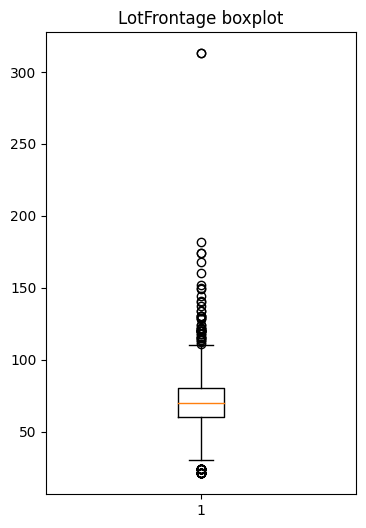

LotFrontage mean:  70.66339285714285
LotFrontage median:  70.0
LotFrontage mode:  0    60.0
Name: LotFrontage, dtype: float64


In [ ]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_data['LotFrontage'].dropna())
plt.title('LotFrontage boxplot')
plt.show()


print('LotFrontage mean: ', train_data['LotFrontage'].mean())
print('LotFrontage median: ', train_data['LotFrontage'].median())
print('LotFrontage mode: ', train_data['LotFrontage'].mode())

# There are a lot of outliers so we chose to impute using median rather than mean

train_data['LotFrontage'] = train_data['LotFrontage'].fillna(train_data['LotFrontage'].median())

## Splitting, Encoding

In [ ]:
# Create a copy of train data
train_df = train_data.copy()

In [ ]:
# Training on log(y) to normalize y distribution did not improve performance
# train_df['SalePrice'] = np.log(train_df['SalePrice'])

# Define ordinal mappings for the specified columns
ordinal_mappings = {
    "LotShape": {"Reg": 0, "IR1": 1, "IR2": 2, "IR3": 3},
    "Utilities": {"ELO": 0, "NoSeWa": 1, "NoSewr": 2, "AllPub": 3},
    "LandSlope": {"Gtl": 0, "Mod": 1, "Sev": 2},
    "ExterQual": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
    "ExterCond": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
    "HeatingQC": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
    "KitchenQual": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
    "Functional": {"Sal": 0, "Sev": 1, "Maj2": 2, "Maj1": 3, "Mod": 4, "Min2": 5, "Min1": 6, "Typ": 7},
    "PavedDrive": {"N": 0, "P": 1, "Y": 2},
    "BsmtQual": {"Po":0, "Fa":1, "TA":2, "Gd":3, "Ex":4, "Missing": -1},
    "BsmtCond": {"Po":0, "Fa":1, "TA":2, "Gd":3, "Ex":4, "Missing": -1},
    "BsmtExposure": {"No":0, "Mn":1, "Av":2, "Gd":3, "Missing": -1},
    "BsmtFinType1": {"Unf":0, "LwQ":1, "Rec":2, "BLQ":3, "ALQ":4, "GLQ":5, "Missing": -1},
    "BsmtFinType2": {"Unf":0, "LwQ":1, "Rec":2, "BLQ":3, "ALQ":4, "GLQ":5, "Missing": -1},
    "FireplaceQu": {"Po":0, "Fa":1, "TA":2, "Gd":3, "Ex":4, "Missing": -1},
    "GarageFinish": {"Unf":0, "RFn": 1, "Fin": 2, "Missing": -1},
    "GarageQual": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4, "Missing": -1},
    "GarageCond": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4, "Missing": -1},
    "PoolQC": {"Fa": 0, "TA": 1, "Gd": 2, "Ex": 3, "Missing": -1},
    "Fence": {"MnWw":0, "GdWo":1, "MnPrv":2, "GdPrv":3, "Missing": -1}
}


# Perform ordinal encoding for the specified columns
for column, mapping in ordinal_mappings.items():
    if column in train_df.columns:
      train_df[column] = train_df[column].fillna('Missing')
      train_df[column] = train_df[column].map(mapping)

# List of other categorical columns to one-hot encode
categorical_columns = [
    "MSZoning", "Street", "Alley", "LandContour", "Condition1", "Condition2",
    "HouseStyle", "RoofMatl", "MasVnrType", "Foundation",
    "Heating", "CentralAir", "Electrical",
    "GarageType", "MiscFeature", "SaleType", "SaleCondition",
    "BldgType", "RoofStyle",
    # "LotConfig"
]

# One-hot encode other categorical columns
train_df = pd.get_dummies(train_df, columns=categorical_columns)

# List of ordinal columns to label encode
ordinal_columns = ["OverallQual", "OverallCond"]

# Label encode ordinal columns
label_encoder = LabelEncoder()
for column in ordinal_columns:
    train_df[column] = label_encoder.fit_transform(train_df[column])

# List of high cardinality columns to target encode
target_columns = ["Neighborhood", "Exterior1st", "Exterior2nd", "MSSubClass"]
target_encoder = TargetEncoder(cols=target_columns)
train_df[target_columns] = target_encoder.fit_transform(train_df[target_columns], train_df['SalePrice'])

In [ ]:
train_df.head(20)

,MSSubClass,LotFrontage,LotArea,LotShape,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolQC,Fence,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed
0,240152.540540,65.0,8450,0,198709.251283,5,3,2003,2003,217004.967480,217758.752599,196.0,3,2,3,2,0,5,706,0,150,856,4,856,854,1710,1,0,2,1,3,1,3,8,7,0,-1,2003.0,1,2,548,2,2,0,61,0,0,-1,-1,0,2,2008,208500,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
1,186931.576402,80.0,9600,0,200681.524451,4,6,1976,1976,151768.922260,151848.900957,0.0,2,2,3,2,3,4,978,0,284,1262,4,1262,0,1262,0,1,2,0,3,1,2,6,7,1,2,1976.0,1,2,460,2,2,298,0,0,0,-1,-1,0,5,2007,181500,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
2,240152.540540,68.0,11250,1,198709.251283,5,3,2001,2002,217004.967480,217758.752599,162.0,3,2,3,2,1,5,486,0,434,920,4,920,866,1786,1,0,2,1,3,1,3,6,7,1,2,2001.0,1,2,608,2,2,0,42,0,0,-1,-1,0,9,2008,223500,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
3,169293.915344,60.0,9550,1,209609.217578,5,3,1915,1970,155652.985695,173027.968752,0.0,2,2,2,3,0,4,216,0,540,756,3,961,756,1717,1,0,1,0,3,1,3,7,7,1,3,1998.0,0,3,642,2,2,0,35,272,0,-1,-1,0,2,2006,140000,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,240152.540540,84.0,14260,1,318919.827482,6,3,2000,2000,217004.967480,217758.752599

In [ ]:
num_columns = train_df.shape[1]
print(f"Number of columns in the DataFrame: {num_columns}")

Number of columns in the DataFrame: 158


In [ ]:
features = train_df.drop(columns=['SalePrice'])  # Separate features
target = train_df['SalePrice']  # Target variable

In [ ]:
# feat_to_keep_from_lasso = ['MSSubClass', 'LotArea', 'Neighborhood', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'BsmtExposure', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'KitchenAbvGr', 'KitchenQual', 'Fireplaces', 'GarageFinish', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'PoolQC', 'Condition1_Norm', 'Condition2_PosN', 'RoofMatl_WdShngl', 'SaleType_New', 'BldgType_1Fam', 'RoofStyle_Gable']
feat_to_keep_from_lasso = ['MSSubClass', 'Neighborhood', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'BsmtExposure', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'KitchenQual', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'PoolQC', 'Condition1_Norm', 'Condition2_PosN', 'RoofMatl_WdShngl', 'SaleType_New', 'BldgType_1Fam', 'RoofStyle_Gable']
features = features[feat_to_keep_from_lasso]
# features

Using feature selection with Lasso actually improved performance for some of our models.

This helps to simplify the dataset to make training more effective

## Heatmaps

In [ ]:
# Plot the correlation matrix (first separate features and Y variable),
# Check if there is high correlation between the given numerical features (Threshold >=0.9).
# If yes, drop those highly correlated features from the dataframe.

In [ ]:
# Partial heatmap that is easier to visualize

# sub_features = features[['MSSubClass', 'LotFrontage', 'LotArea', 'LotShape', 'OverallQual',
#                          'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
#                          'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
#                          '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath']]
# correlation_matrix_sub = sub_features.corr()
# plt.figure(figsize=(18, 12))
# sns.heatmap(correlation_matrix_sub, annot=True, fmt=".2f", cmap='coolwarm')
# plt.title('Correlation Matrix')
# plt.show()

In [ ]:
# Partial heatmap that is easier to visualize

# sub_features = features[['BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
#                          'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
#                          'EnclosedPorch', 'ScreenPorch', 'PoolQC', 'Fence', 'MiscVal', 'MoSold', 'YrSold', 'MSZoning_C (all)',
#                          'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM']]
# # sub_features = features[['KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
# #                          'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
# #                          'EnclosedPorch', 'PoolQC']]
# correlation_matrix_sub = sub_features.corr()
# plt.figure(figsize=(18, 12))
# sns.heatmap(correlation_matrix_sub, annot=True, fmt=".2f", cmap='coolwarm')
# plt.title('Correlation Matrix')
# plt.show()

Highly Correlated Features to Drop: 
 set()

Number of columns in the DataFrame after dropping collinear features: 23


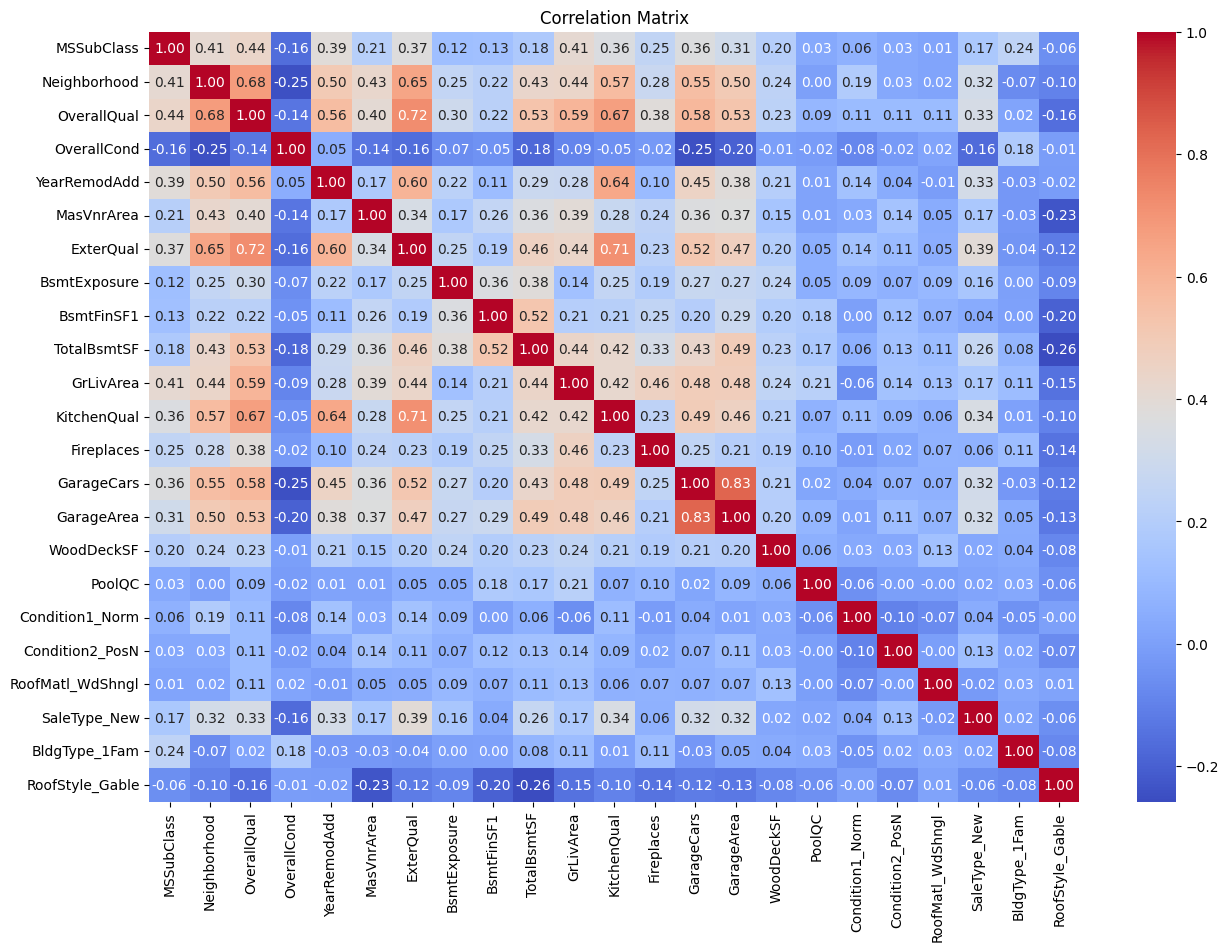

In [ ]:
# Full heatmap

# Calculate the correlation matrix
correlation_matrix = features.corr()

threshold = 0.85

# Find highly correlated features
highly_correlated = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) >= threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated.add(colname)
print("Highly Correlated Features to Drop: \n", highly_correlated)
# Drop highly correlated features from the dataframe
features = features.drop(columns=highly_correlated)

num_columns = features.shape[1]
print(f"\nNumber of columns in the DataFrame after dropping collinear features: {num_columns}")

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Split and transform data

In [ ]:
# Apply the following pre-processing steps

In [ ]:
features

,MSSubClass,Neighborhood,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,ExterQual,BsmtExposure,BsmtFinSF1,TotalBsmtSF,GrLivArea,KitchenQual,Fireplaces,GarageCars,GarageArea,WoodDeckSF,PoolQC,Condition1_Norm,Condition2_PosN,RoofMatl_WdShngl,SaleType_New,BldgType_1Fam,RoofStyle_Gable
0,240152.540540,198709.251283,5,3,2003,196.0,3,0,706,856,1710,3,0,2,548,0,-1,1,0,0,0,1,1
1,186931.576402,200681.524451,4,6,1976,0.0,2,3,978,1262,1262,2,1,2,460,298,-1,0,0,0,0,1,1
2,240152.540540,198709.251283,5,3,2002,162.0,3,1,486,920,1786,3,1,2,608,0,-1,1,0,0,0,1,1
3,169293.915344,209609.217578,5,3,1970,0.0,2,0,216,756,1717,3,1,3,642,0,-1,1,0,0,0,1,1
4,240152.540540,318919.827482,6,3,2000,350.0,3,2,655,1145,2198,3,1,3,836,192,-1,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,240152.540540,192529.153808,4,3,2000,0.0,2,0,0,953,1647,2,1,2,460,0,-1,1,0,0,0,1,1
1456,186931.576402,189030.920125,4,4,1988,119.0,2,0,790,1542,2073,2,2,2,500,349,-1,1,0,0,0,1,1
1457,169293.915344,209609.217578,5,7,2006,0.0,4,0,275,1152,2340,3,2,1,252,0,-1,1,0,0,0,1,1
1458,186931.576402,146445.858536,3,4,1996,0.0,2,1,49,1078,1078,3,0,1,240,366,-1,1,0,0,0,1,0


In [ ]:
for col in features.columns:
  if features[col].isnull().any() == True:
    print(col)
    print(features[col].isnull().sum())

In [ ]:
y = train_df['SalePrice'].values.reshape(-1, 1)

from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(features, y, test_size=0.4, random_state=42) # 60/20/20
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
X_train_tree = X_train.copy()
X_valid_tree = X_valid.copy()
X_test_tree = X_test.copy()
y_train_tree = y_train.copy()
y_valid_tree = y_valid.copy()
y_test_tree = y_test.copy()

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [ ]:
# Add a column of ones to the feature matrices
X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_valid = np.hstack((np.ones((X_valid.shape[0], 1)), X_valid))
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

## Applying ML Techniques

### Apply Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred))
print("Linear Regression RMSE:", rmse_lr)

r2_test_lr = r2_score(y_test, y_pred)
print("R^2 score for testing set:", r2_test_lr)

Linear Regression RMSE: 46244.55612721138
R^2 score for testing set: 0.6850819108227902


In [ ]:
def get_report(y_pred, y_test):
    """
    function to Report the first 3 and last 3 predictions on X_test,
    along with the actual labels in y_test.

    Returns a dataframe with 6 rows.
    """
    preds = np.concatenate([y_pred[:3], y_pred[-3:]])
    actuals = np.concatenate([y_test[:3], y_test[-3:]])
    df_compare = pd.DataFrame({'Prediction': preds,
                               'Actual':actuals})
    df_compare['Position'] = [1, 2, 3, len(y_pred) - 2, len(y_pred) - 1, len(y_pred)]
    df_compare = df_compare.set_index('Position')
    return df_compare

get_report(y_pred.flatten(), y_test.flatten())

,Prediction,Actual
Position,,
1,357874.0,415298
2,143946.0,158000
3,96232.0,121600
272,108350.0,139000
273,163374.0,149900
274,340260.0,394432


### Apply Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge = Ridge()
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
ridge_grid = GridSearchCV(ridge, param_grid=ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)

# Best parameters
best_ridge_model = ridge_grid.best_estimator_
y_pred = best_ridge_model.predict(X_test)
rmse_rr = np.sqrt(mean_squared_error(y_test, y_pred))
print("Ridge Regression RMSE:", rmse_rr)

r2_test_rr = r2_score(y_test, y_pred)
print("R^2 score for testing set:", r2_test_rr)

get_report(y_pred.flatten(), y_test.flatten())

Ridge Regression RMSE: 46155.83831479674
R^2 score for testing set: 0.6862890602335975


,Prediction,Actual
Position,,
1,357313.259899,415298
2,143916.700943,158000
3,95986.335403,121600
272,108915.127440,139000
273,163220.779992,149900
274,339821.550805,394432


### Apply Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV

lasso = Lasso()

param_dist = {
    'alpha': np.logspace(0.2, 10, 100),  # Range of alpha values
    'max_iter': [7500, 10000],  # Range of max_iter values
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(lasso, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Best estimator
best_lasso_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_lasso_model.predict(X_test)

rmse_la = np.sqrt(mean_squared_error(y_test, y_pred))
print("Lasso Regression RMSE:", rmse_la)

r2_test_la = r2_score(y_test, y_pred)
print("R^2 score for testing set:", r2_test_la)

get_report(y_pred.flatten(), y_test.flatten())

Lasso Regression RMSE: 43108.7332770633
R^2 score for testing set: 0.7263427866661212


,Prediction,Actual
Position,,
1,342981.688661,415298
2,136936.851363,158000
3,106786.001590,121600
272,115330.029975,139000
273,149297.749464,149900
274,329028.072972,394432


These features were set to 0:  ['bias']
['MSSubClass', 'Neighborhood', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'BsmtExposure', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'KitchenQual', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'PoolQC', 'Condition1_Norm', 'Condition2_PosN', 'RoofMatl_WdShngl', 'SaleType_New', 'BldgType_1Fam', 'RoofStyle_Gable']


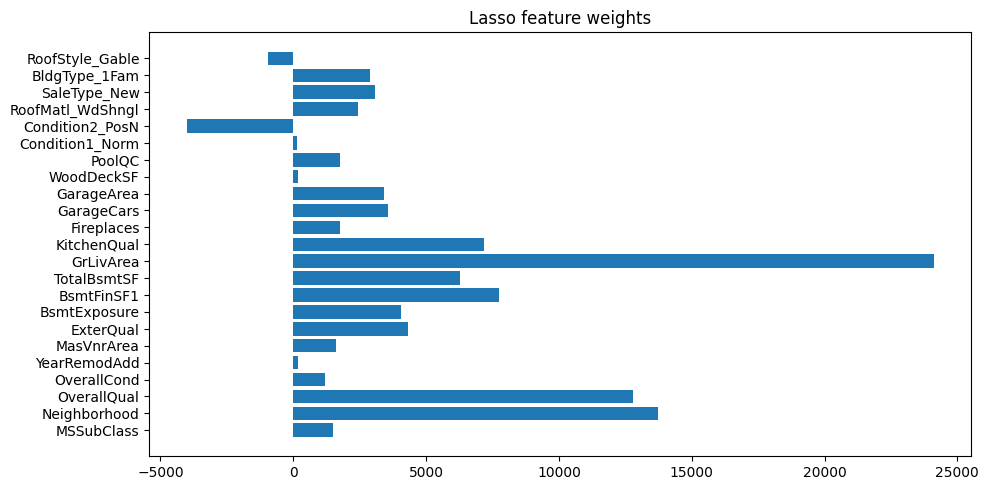

In [ ]:
# Feature importance
lasso_weights = best_lasso_model.coef_
# lasso_weights = lasso_weights.reshape(1,-1)[0]
feature_labels = ['bias'] + list(X_train_tree.columns)

zero_coefficient_indices = np.where(np.isclose(lasso_weights, 0.0))[0]
zero_coefficient_features = [feature_labels[i] for i in zero_coefficient_indices]
print('These features were set to 0: ', zero_coefficient_features)

non_zero_coefficient_indices = np.where(~np.isclose(lasso_weights, 0.0))[0]
non_zero_coefficient_features = [feature_labels[i] for i in non_zero_coefficient_indices]
non_zero_weights = lasso_weights[non_zero_coefficient_indices]
print(non_zero_coefficient_features)

plt.figure(figsize=(10, 5))
plt.title("Lasso feature weights")
plt.barh(non_zero_coefficient_features, non_zero_weights, align='center')
# plt.xticks(range(len(top_indices_xgboost)), top_feature_names_xgboost, rotation=45)
plt.tight_layout()
plt.show()

### Apply ElasticNet Regression

In [ ]:
from sklearn.linear_model import ElasticNet

elasticnet = ElasticNet()

param_dist = {
    'alpha': np.logspace(0, 10, 100),  # Range of alpha values
    'l1_ratio': np.linspace(0, 1, 100),   # Range of l1_ratio values
    'max_iter': [10000, 15000],
    }

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    elasticnet, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42
)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Best estimator
best_xgb_model = random_search.best_estimator_

# Make predictions on the test set using the best estimator
y_pred = best_xgb_model.predict(X_test)

rmse_er = np.sqrt(mean_squared_error(y_test, y_pred))
print("ElasticNet Regression RMSE:", rmse_er)

r2_test_er = r2_score(y_test, y_pred)
print("R^2 score for testing set:", r2_test_er)

get_report(y_pred.flatten(), y_test.flatten())

ElasticNet Regression RMSE: 44422.87493049765
R^2 score for testing set: 0.7094039544635629


,Prediction,Actual
Position,,
1,316030.499295,415298
2,148191.295398,158000
3,104855.660694,121600
272,130495.966032,139000
273,160144.003205,149900
274,309626.252794,394432


### Apply XGBoost with Hyperparameter Tuning

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid to search
param_grid = {
    'max_depth': [3, 5, 7, 15],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
}


xgb_regressor = xgb.XGBRegressor()


random_search = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_root_mean_squared_error', # RMSE scoring
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Perform the Randomized Search with Cross-Validation
random_search.fit(X_train, y_train)

# Best estimator
best_xgb_model = random_search.best_estimator_

# Make predictions on the test set
predictions = best_xgb_model.predict(X_test)

# Calculate the RMSE
rmse_xgboost = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE on the test set: %.2f" % rmse_xgboost)

r2_test_xgboost = r2_score(y_test, predictions)
print("R^2 score for test set:", r2_test_xgboost)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
RMSE on the test set: 26232.22
R^2 score for test set: 0.8986680006299249


In [ ]:
# Feature importance
feature_importances_xgboost = best_xgb_model.feature_importances_
sorted_indices_xgboost = np.argsort(feature_importances_xgboost)[::-1]
top_indices_xgboost = sorted_indices_xgboost[:10]

# Get the sorted feature importances and names
top_feature_importances_xgboost = feature_importances_xgboost[top_indices_xgboost]
top_feature_names_xgboost = np.array(['bias'] + list(X_train_tree.columns))[top_indices_xgboost]

plt.figure(figsize=(12, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(len(top_indices_xgboost)), top_feature_importances_xgboost, align='center')
plt.xticks(range(len(top_indices_xgboost)), top_feature_names_xgboost, rotation=45)
plt.tight_layout()
plt.show()

NameError: ignored

### Apply Catboost

In [ ]:
# pip install catboost

In [ ]:
# from catboost import CatBoostRegressor

# # Define the parameter grid to search
# param_grid = {
#     'depth': [4, 8, 15],
#     'learning_rate': [0.01, 0.03, 0.1],
#     'bagging_temperature': [0.0, 0.2, 0.4, 0.8]
# }

# catboost_regressor = CatBoostRegressor(
#     loss_function='RMSE',
#     verbose=False
# )

# random_search = RandomizedSearchCV(
#     estimator=catboost_regressor,
#     param_distributions=param_grid,
#     n_iter=20,  # Number of parameter settings that are sampled
#     scoring='neg_root_mean_squared_error',
#     cv=2,
#     verbose=2,
#     random_state=42,
#     n_jobs=-1
# )

# random_search.fit(X_train_tree, y_train_tree)

# # Best estimator
# best_catboost_model = random_search.best_estimator_

# # Make predictions on the validation set
# predictions = best_catboost_model.predict(X_valid_tree)

# # Calculate the RMSE
# rmse = np.sqrt(mean_squared_error(y_valid_tree, predictions))
# print("RMSE on the validation set: %.2f" % rmse)

# r2_test = r2_score(y_test_tree, predictions)
# print("R^2 score for test set:", r2_test)

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor

catboost_regressor = CatBoostRegressor(
    loss_function='RMSE',
    verbose=False
)

regressor = catboost_regressor.fit(X_train, y_train)

# Make predictions on the test set
predictions = regressor.predict(X_test)

# Calculate the RMSE
rmse_catboost = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE on the validation set: %.2f" % rmse_catboost)

r2_test_catboost = r2_score(y_test, predictions)
print("R^2 score for test set:", r2_test_catboost)

RMSE on the validation set: 27912.56
R^2 score for test set: 0.8852703096429708


    Feature Name  Importance
11     GrLivArea   21.122012
3    OverallQual   15.064328
2   Neighborhood    9.981775
10   TotalBsmtSF    8.455075
12   KitchenQual    7.108046
9     BsmtFinSF1    6.946364
14    GarageCars    4.225315
1     MSSubClass    3.818811
5   YearRemodAdd    3.464912
15    GarageArea    3.164962


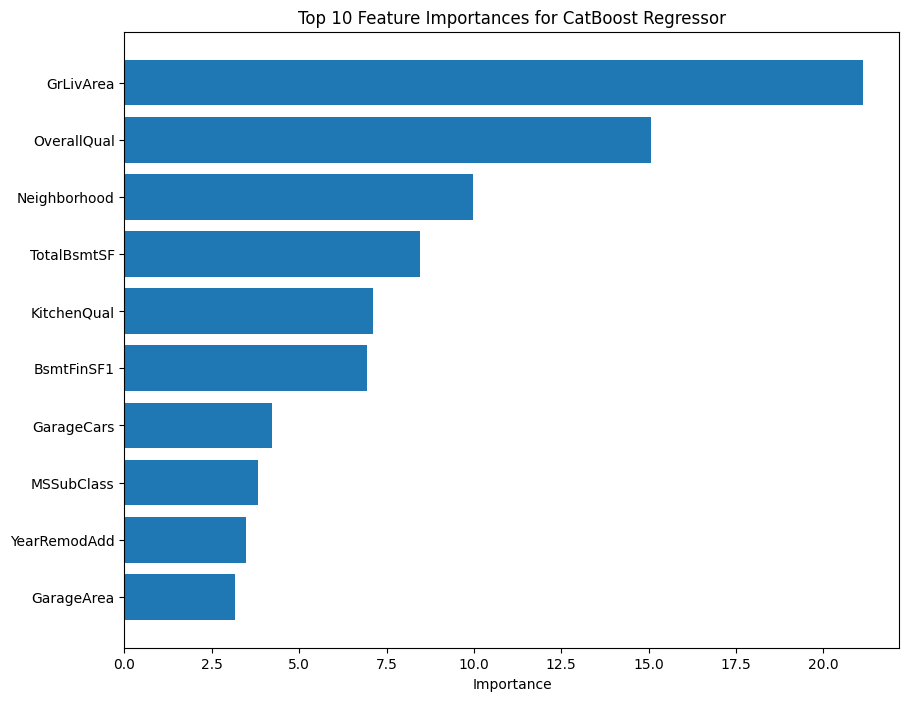

In [ ]:
# Feature Importance
feature_importances = catboost_regressor.get_feature_importance()
feature_names = ['bias'] + list(X_train_tree.columns)
feature_importance_df = pd.DataFrame({'Feature Name': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_10_features = feature_importance_df.head(10)
print(top_10_features)

top_10_features = top_10_features.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(top_10_features['Feature Name'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances for CatBoost Regressor')
plt.show()



## SVR and Random Forest Regressor

In [ ]:
from sklearn.svm import SVR

svr_param_dist = {
    'C': np.logspace(-3, 3, 7),
    'epsilon': np.linspace(0.1, 1.0, 10),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7))
}

svr_model = SVR()
svr_random_search = RandomizedSearchCV(svr_model, svr_param_dist, n_iter=30, scoring='neg_mean_squared_error', cv=5, random_state=42)
svr_random_search.fit(X_train, np.ravel(y_train))

# Best estimator
best_svr_model = svr_random_search.best_estimator_

# Make predictions on the test set
predictions = best_svr_model.predict(X_test)

# svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
# svr_model.fit(X_train, y_train)

# Make predictions on the test set
# predictions = svr_model.predict(X_test)

rmse_svr = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE on the test set: %.2f" % rmse_svr)

r2_test_svr = r2_score(y_test, predictions)
print("R^2 score for test set:", r2_test_svr)


RMSE on the test set: 43670.42
R^2 score for test set: 0.7191650334984943


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, np.ravel(y_train))

predictions = rf_model.predict(X_test)

# rf_model = RandomForestRegressor()
# rf_random_search = RandomizedSearchCV(rf_model, rf_param_dist, n_iter=20, scoring='neg_mean_squared_error', cv=5, random_state=42)
# rf_random_search.fit(X_train, np.ravel(y_train))

# Best estimator
# best_rf_model = rf_random_search.best_estimator_

# Make predictions on the test set
# predictions = best_rf_model.predict(X_test)


rmse_rf = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE on the test set: %.2f" % rmse_rf)

r2_test_rf = r2_score(y_test, predictions)
print("R^2 score for test set:", r2_test_rf)

RMSE on the test set: 32590.37
R^2 score for test set: 0.8435934496620892


## Model Comparison

In [ ]:
df = pd.DataFrame({'Root Mean Squared Error': [rmse_lr, rmse_rr, rmse_la, rmse_er, rmse_xgboost, rmse_catboost, rmse_svr, rmse_rf], 'R Squared': [r2_test_lr, r2_test_rr, r2_test_la, r2_test_er, r2_test_xgboost, r2_test_catboost, r2_test_svr, r2_test_rf]}, index= ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'ElasticNet Regression', 'XGBoost', 'CatBoost', 'Support Vector Regression', 'Random Forest Regressor'])

df = df.round(3)

In [ ]:
df

,Root Mean Squared Error,R Squared
Linear Regression,46244.556,0.685
Ridge Regression,46235.556,0.685
Lasso Regression,43108.733,0.726
ElasticNet Regression,44422.875,0.709
XGBoost,26232.224,0.899
CatBoost,27912.563,0.885
Support Vector Regression,43670.423,0.719
Random Forest Regressor,32590.369,0.844
